In [1]:
# source('./../../my_utils/funcs_R/my_rutils.R')
source('helper_funs.r')
save.dir <- './../results/merfish/'
dir.create(save.dir)

fs <- 4
fs.small <- 3

# region to which skewed panel is skewed 
skew.region <- 'ventricles' #'fiber_tracts' 'habenula' 'dentate_gyrus'

Warning message in dir.create(save.dir):
“'./../results/merfish' already exists”


In [4]:
suppressMessages(suppressWarnings(library(DESeq2)))
suppressMessages(suppressWarnings(library(edgeR)))
suppressMessages(suppressWarnings(library(sctransform)))
suppressMessages(suppressWarnings(library(RColorBrewer)))
suppressMessages(suppressWarnings(library(Matrix.utils)))

ERROR: Error in library(Matrix.utils): there is no package called ‘Matrix.utils’


## DATA

In [194]:
data.dir <- './../data/merfish/'
fname <- paste0(data.dir,'merfish.rds')
merfish <- readRDS(file = fname)

gexp <- merfish$gexp
genes <- rownames(gexp)
meta <- merfish$meta
dim(gexp)
dim(meta)
head(genes)

[1]   483 10755

[1] 10755    24

[1] "Oxgr1" "Htr1a" "Htr1b" "Htr1d" "Htr1f" "Htr2a"

In [195]:
## create color legends
col.region.coarse <- meta$col.region.coarse
names(col.region.coarse) <- rownames(meta)

leg.col.region.coarse <- names(sort(table(meta$col.region.coarse)))
names(leg.col.region.coarse) <- names(sort(table(meta$reg.coarse)))
leg.col.region.coarse
table(col.region.coarse)
table(meta$reg.coarse)

ventricles      habenula dentate_gyrus  fiber_tracts 
    "#CC00FF"     "#00FF66"     "#FF0000"        "blue"

col.region.coarse
#00FF66 #CC00FF #FF0000    blue 
   1211     792    2051    6701 


dentate_gyrus  fiber_tracts      habenula    ventricles 
         2051          6701          1211           792 

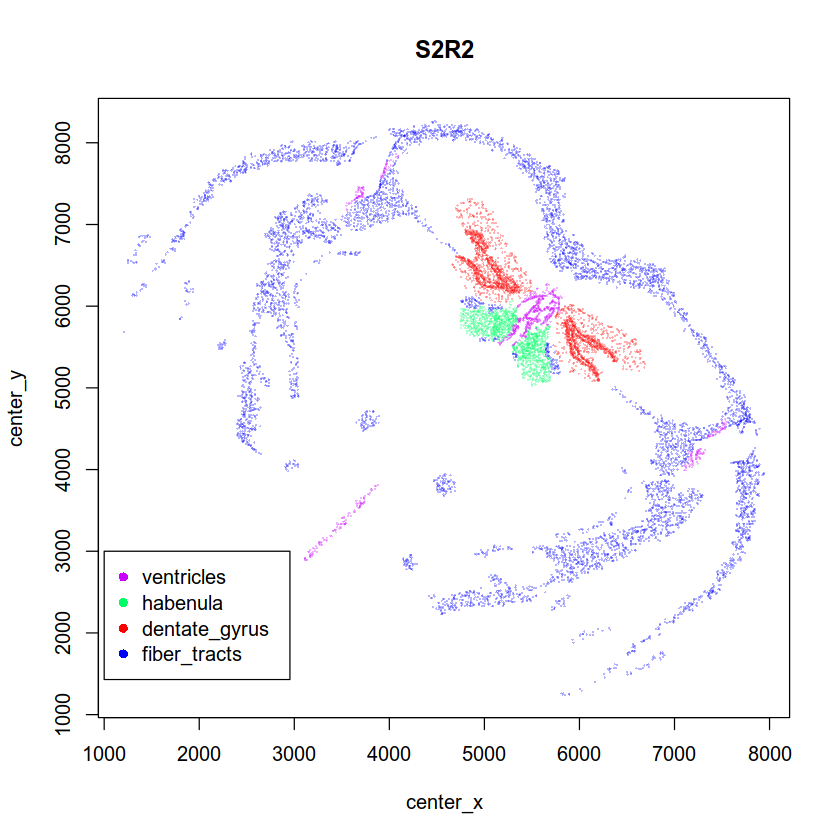

In [196]:
## look 
options(repr.plot.width=7, repr.plot.height=7)
plot(meta[,c('center_x','center_y')], 
     pch=16, cex=0.25, col=scales::alpha(col.region.coarse,0.3), 
     main = unique(meta$sample))

legend(x = 1000, y = 3000, pch = 16, 
       legend = names(leg.col.region.coarse), col = leg.col.region.coarse)

## NORMALIZE

#### scTransform

In [197]:
suppressMessages(norm.sct.obj <- sctransform::vst(gexp, n_genes = NULL))
norm.sct <- norm.sct.obj$y
norm.sct[norm.sct<0] <- 0
dim(gexp)
dim(norm.sct)

  |======================================================================| 100%
  |======================================================================| 100%


[1]   483 10755

[1]   481 10755

In [198]:
## keep same genes as ones kept by sctransform
genes <- rownames(norm.sct)
gexp <- gexp[genes,]

#### library size, DESeq2, TMM, and volume normalization 

In [199]:
## scaling factors
sf.libsize <- colSums(gexp) / median(colSums(gexp), na.rm = T)
sf.DESeq <- DESeq2::estimateSizeFactorsForMatrix(as.matrix(gexp), type = 'poscounts')
sf.TMMwsp <- edgeR::calcNormFactors(gexp, method = 'TMMwsp')  ## multiplied not divided
sf.volume <- meta[colnames(gexp), 'volume'] / median(meta[colnames(gexp), 'volume'], na.rm = T)
names(sf.volume) <- colnames(gexp)

In [200]:
norm.none <- gexp
norm.deseq <- t(t(gexp)/sf.DESeq)
norm.tmm <- t(t(gexp)*sf.TMMwsp)
norm.libsize <- t(t(gexp)/sf.libsize)
norm.vol <- t(t(gexp)/sf.volume)
all.norms <- list(nonorm = norm.none,
                 libsize = norm.libsize,
                 deseq = norm.deseq,
                 tmm = norm.tmm,
                 volume = norm.vol,
                 sct = norm.sct)


In [201]:
norms <- names(all.norms)
norms

[1] "nonorm"  "libsize" "deseq"   "tmm"     "volume"  "sct"

## DE GENES

In [202]:
cluster <- meta[, 'reg.coarse']
names(cluster) <- rownames(meta)
table(cluster)

cluster
dentate_gyrus  fiber_tracts      habenula    ventricles 
         2051          6701          1211           792 

In [203]:
## get log fold changes and adjusted p-values 

lfcs.all <- lapply(all.norms, function(counts.norm) {
    curr.cluster <- cluster[colnames(counts.norm)]
    names(curr.cluster) <- colnames(counts.norm)
    curr.lfcs <- find.log.fold.change(counts.norm, curr.cluster, log2)
    
    curr.lfcs
})



p.vals.all <- lapply(all.norms, function(counts.norm) {
    curr.cluster <- cluster[colnames(counts.norm)]
    names(curr.cluster) <- colnames(counts.norm)
    curr.pvals <- find.cluster.de.genes(counts.norm, cell.com = curr.cluster, 
                                        test.alt = 'greater')
    curr.pvals
})

p.vals.all.adj <- lapply(p.vals.all, function(curr.pvals) {
    curr.pvals.adj <- matrix(p.adjust(curr.pvals, method = 'BH'), 
                             nrow = nrow (curr.pvals), ncol = ncol(curr.pvals))
    colnames(curr.pvals.adj) <- colnames(curr.pvals)
    rownames(curr.pvals.adj) <- rownames(curr.pvals)
    curr.pvals.adj
})

In [204]:
## pick DE genes based on adjusted p-value threshold (0.05) and log fold change threshold (0.25)
p.thresh <- 0.05
lfc.thresh <- 0.25

de.genes <- lapply(norms, function(curr.norm) {
    curr.pvals <- p.vals.all.adj[[curr.norm]]
    curr.lfcs <- lfcs.all[[curr.norm]]
    
    curr.groups <- colnames(curr.pvals)
    
    curr.de.genes <- lapply(curr.groups, function(curr.group) {
        curr.group.pvals <- curr.pvals[,curr.group]
        curr.group.lfcs <- curr.lfcs[names(curr.group.pvals),curr.group]
        curr.group.de.genes <- names(curr.group.pvals)[curr.group.pvals<p.thresh & abs(curr.group.lfcs)>lfc.thresh]
        curr.group.de.genes.stats <- cbind(curr.group.pvals[curr.group.de.genes], curr.group.lfcs[curr.group.de.genes])
        colnames(curr.group.de.genes.stats) <- c('p.adj','logFC')
        curr.group.de.genes.stats
    })
    names(curr.de.genes) <- curr.groups
    curr.de.genes
})
names(de.genes) <- norms

## SKEWED GENE PANELS

In [205]:
regions <- unique(cluster)
regions

[1] "fiber_tracts"  "ventricles"    "habenula"      "dentate_gyrus"

In [206]:
## find skewed genes: genes that are DE with any norm
genesets <- lapply(regions, function(r) {
    Reduce(union, lapply(de.genes, function(curr.norm) {
        rownames(curr.norm[[r]][order(curr.norm[[r]][,'p.adj']),])
    }))
    
})
names(genesets) <- regions

## number of skewed genes for each tissue anatomical region
sapply(genesets, function(x) {print(length(x))})

## create skewed gene panels of 100 genes for each region
set.seed(0)
n <- 100
genesets <- lapply(genesets, function(x) {sample(x,n)})

## create a non-skewed gene panel by randomly sampling 100 genes      
geneset.x <- sample(genes, n)   
genesets[['random']] <- geneset.x

[1] 109
[1] 144
[1] 155
[1] 102


fiber_tracts    ventricles      habenula dentate_gyrus 
          109           144           155           102

#### gene panel heatmaps

In [207]:
dir.create(paste0(save.dir,'heatmaps'))

Warning message in dir.create(paste0(save.dir, "heatmaps")):
“'results/merfish/heatmaps' already exists”


In [208]:
## average region gene expression
gexp.agg <- as.matrix(aggregate.Matrix(t(gexp[,names(cluster)]), groupings = cluster))
gexp.mean <- t(gexp.agg[regions,]/as.vector(table(cluster)[regions]))

In [209]:
## full gene panel: heatmap gene order 
### order should be: [non DE genes][DE genes for more than one region][specific DE genes]

# get skewed geneset genes (minus random geneset)
hm.genes <- unlist(genesets[1:4])

# find which genes are in multiple genesets 
hm.genes.dups <- unique(hm.genes[duplicated(hm.genes)])
length(hm.genes.dups)

# remove duplicated genes (all instances)
hm.genes <- hm.genes[! hm.genes %in% hm.genes.dups]
length(hm.genes)

# add one instance of duplicate genes at the front
hm.genes <- c(hm.genes.dups, hm.genes)
length(hm.genes)

# add non DE genes to the front (nongs=non-genesets)
hm.genes.nongs <- rownames(gexp)[! rownames(gexp) %in% hm.genes]
hm.genes <- c(hm.genes, hm.genes.nongs)
length(hm.genes)

# red-blue color map
htmp.col <- rev(colorRampPalette(brewer.pal(11, "RdBu"))(100))

[1] 73

[1] 248

[1] 321

[1] 481

In [210]:
## pretty names and re-order
gs.names <- c('Fiber tracts', 'Ventricles', 'Habenula', 'Dentate gyrus', NA)
names(gs.names) <- names(genesets)
gs.order <- c(2,3,1,4)
gs.names[gs.order]

ventricles        habenula    fiber_tracts   dentate_gyrus 
   "Ventricles"      "Habenula"  "Fiber tracts" "Dentate gyrus"

In [211]:
## heatmap mean gene exp full panel with color bar 
options(repr.plot.width=7, repr.plot.height=5)
pdf(paste0(save.dir,'heatmaps/heatmap_full_colorbar_div.pdf'), width = 7, height = 5)
gplots::heatmap.2(gexp.mean[rev(hm.genes),gs.order], scale = 'row', col = htmp.col, 
        Colv = NA, Rowv = NA, 
        ColSideColors = leg.col.region.coarse[colnames(gexp.mean[,gs.order])],
       labRow = FALSE, labCol = FALSE,
        margins = c(3.8,2.1),
          trace = 'none',
          keysize = 5, density.info = 'none',
          key.title = NA, key.xlab = 'Gene Z-score'
          
       )
title(ylab=paste('Genes\nFull gene panel'), line=0.5, cex.lab=1)
title(xlab=paste('Cells'), line=4, cex.lab=1)
dev.off()

Warning message in gplots::heatmap.2(gexp.mean[rev(hm.genes), gs.order], scale = "row", :
“Discrepancy: Rowv is FALSE, while dendrogram is `both'. Omitting row dendogram.”
Warning message in gplots::heatmap.2(gexp.mean[rev(hm.genes), gs.order], scale = "row", :
“Discrepancy: Colv is FALSE, while dendrogram is `column'. Omitting column dendogram.”


png 
  2

In [212]:
## heatmap mean gene exp skewed panel
s <- 'row'

for (gs in skew.region){
    foo.genes <- genesets[[gs]]
    hm.genes.gs <- hm.genes[hm.genes %in% foo.genes]
    
    pdf(paste0(save.dir,'heatmaps/heatmap_',gs,'.pdf'), width = 7, height = 5)
    par(mfrow = c(1,1), mar = c(5.1, 4.1, 4.1, 2.1))

    heatmap(gexp.mean[hm.genes.gs,gs.order], scale = 'row', col = htmp.col, 
            Colv = NA, Rowv = NA, 
            ColSideColors = leg.col.region.coarse[colnames(gexp.mean[,gs.order])],
           labRow = FALSE, labCol = FALSE,
#               trace = 'none',
            margins = c(3.8,2.1)
           )
    if (gs == 'random'){
        title(ylab=paste('Genes\nNon-skewed gene panel'), line=0.5, cex.lab=2)
    } else {
        title(ylab=paste0('Genes\n', gs.names[gs], '-skewed gene panel'), line=0.5, cex.lab=2)
    }
    title(xlab=paste('Cells'), line=4, cex.lab=2)
    dev.off()
}


#### gene panel count subsets

In [213]:
counts.subsets <- lapply(genesets, function(gs) {
    curr.subset.counts <- gexp[gs,]
    curr.empty.cells <- colSums(curr.subset.counts)==0
    curr.subset.counts <- curr.subset.counts[,!curr.empty.cells]
    curr.subset.counts
})
names(counts.subsets)
sapply(counts.subsets, dim)

[1] "fiber_tracts"  "ventricles"    "habenula"      "dentate_gyrus"
[5] "random"

fiber_tracts,ventricles,habenula,dentate_gyrus,random
100,100,100,100,100
10753,10754,10742,10753,10752


## NORMALIZE SKEWED PANELS

#### scaling factors

In [214]:
skewed.sfs <- lapply(counts.subsets, function(x) {
    curr.libsize <- colSums(x) / median(colSums(x), na.rm = T)
    curr.sf.DESeq <- DESeq2::estimateSizeFactorsForMatrix(as.matrix(x), type = 'poscounts')
    curr.sf.TMMwsp <- edgeR::calcNormFactors(x, method = 'TMMwsp')  ## multiplied not divided
    curr.sf.volume <- meta[colnames(x), 'volume'] / median(meta[colnames(x), 'volume'], na.rm = T)
    names(curr.sf.volume) <- colnames(x)
    
    list(libsize = curr.libsize,
        deseq = curr.sf.DESeq,
        tmm = curr.sf.TMMwsp,
        vol = curr.sf.volume)
})

In [215]:
sf.all <- list(libsize = sf.libsize,
               deseq = sf.DESeq,
               tmm = sf.TMMwsp,
               vol = sf.volume)

#### normalize

In [216]:
skewed.norms <- lapply(names(counts.subsets), function(gs) {
    curr.counts <- counts.subsets[[gs]]
    print(head(rownames(curr.counts)))
    curr.sfs <- skewed.sfs[[gs]]
    
    curr.norm.none <- curr.counts
    curr.norm.libsize <- t(t(curr.counts)/curr.sfs[['libsize']]) 
    curr.norm.deseq <- t(t(curr.counts)/curr.sfs[['deseq']])
    curr.norm.tmm <- t(t(curr.counts)*curr.sfs[['tmm']])
    curr.norm.vol <- t(t(curr.counts)/curr.sfs[['vol']]) 
    suppressMessages(curr.sct <- sctransform::vst(curr.counts, n_genes = NULL))
    curr.norm.sct <- curr.sct$y
    curr.norm.sct[curr.norm.sct<0] <- 0
    
    curr.norms <- list(nonorm = curr.norm.none,
                       libsize = curr.norm.libsize,
                       deseq = curr.norm.deseq,
                       tmm = curr.norm.tmm,
                       volume = curr.norm.vol,
                      sct = curr.norm.sct)
    
    curr.norms
})
names(skewed.norms) <- names(counts.subsets)


[1] "Htr1a"  "Ddr1"   "Adra1b" "Ntsr1"  "Adra2b" "Hrh3"  
  |======================================================================| 100%
  |======================================================================| 100%
[1] "Fzd1"    "Aplnr"   "Gpr20"   "Gpr50"   "Htr2c"   "Vmn1r49"
  |======================================================================| 100%
  |======================================================================| 100%
[1] "Gpr132"  "Rxfp3"   "Galr1"   "Htr7"    "Rxfp2"   "Atp13a5"
  |======================================================================| 100%
  |======================================================================| 100%
[1] "Adrb1"     "Gabbr1"    "Adcyap1r1" "Epha5"     "Drd5"      "Celsr3"   
  |======================================================================| 100%
  |======================================================================| 100%
[1] "Ccr10"   "Lgr5"    "Vmn1r43" "S1pr1"   "Grm5"    "Gabbr2" 
  |===============================

## SCALING FACTOR COMPARISON

In [217]:
dir.create(paste0(save.dir,'scaling_factor_comparison'))

Warning message in dir.create(paste0(save.dir, "scaling_factor_comparison")):
“'results/merfish/scaling_factor_comparison' already exists”


#### scaling factors with skewed panel vs with original panel

In [218]:
options(repr.plot.width=20, repr.plot.height=8)
set.seed(0)

norms.to.include <- c('libsize', 'deseq', 'tmm', 'vol')
norms.names <- c('Library Size', 'DESeq2', 'TMM', 'Cell Volume')
names(norms.names) <- norms.to.include

for (g in skew.region){
    pdf(paste0(save.dir,'scaling_factor_comparison/',g,'_skewed_vs_all_genes_grouped.pdf'), 
        width = 20, height = 5) #, antialias = 'none')
    par(mfrow = c(1,4), mar = c(10.1, 10.1, 6.1, 2.1)) #mar = c(5.1, 4.1, 4.1, 2.1)
    
    curr.sfs.skewed <- skewed.sfs[[g]][norms.to.include]
    curr.common.cells <- Reduce(intersect, lapply(curr.sfs.skewed, names))
    
    for (n in norms.to.include){
        
        curr.sf.skewed <- curr.sfs.skewed[[n]]
        curr.sf.all <- sf.all[[n]]
        
        curr.x <- log10(curr.sf.all[curr.common.cells]+1)
        curr.x.lim <- range(curr.x, na.rm = T)
        
        curr.y <- log10(curr.sf.skewed[curr.common.cells]+1)
        curr.y.lim <- range(curr.y, na.rm = T)
        
        #change color to highlight roi for region skewed geneset
        curr.cols <- col.region.coarse
        curr.cols[meta[names(col.region.coarse), 'reg.coarse'] != g] <- 'grey'
        
        #use all colors for random geneset
        if (g == 'random'){
            curr.cols <- col.region.coarse
        }
        
        
        #reorder when all together
        o <- sample(length(curr.x))
        o <- sample(o)
        
        plot(curr.x[o], curr.y[o], #axes = FALSE,
             pch = 16, cex = 1.5, ##point sizes
             col = scales::alpha(curr.cols[curr.common.cells[o]], 0.25), ##point colors
             cex.axis = fs, cex.main = fs, ##font sizes
             xaxt="n", yaxt="n", bty = 'n', xaxs = 'i', yaxs = 'i', ##axis settings
             xlim = curr.x.lim, ylim = curr.y.lim, xlab = '', ylab = '',  ##axis ranges and labels
             main = paste(norms.names[n])) ##title 
        
        ## axis labels
        title(xlab=paste('Full gene panel'), line=8, cex.lab=4)
        title(ylab=paste('Skewed gene panel'), line=5, cex.lab=4)       
        
        ## axis tick mark formats
        axis(side = 1, at = curr.x.lim, line = 0, cex.axis = fs, lty = 1, labels = FALSE)
        axis(side = 2, at = curr.y.lim, line = 0, cex.axis = fs, lty = 1, labels = FALSE)
        axis(side = 1, line = 0, cex.axis = fs.small, lty = 1, labels = FALSE)
        axis(side = 2, line = 0, cex.axis = fs.small, lty = 1, labels = FALSE)
        axis(side = 1, line = 2.5, cex.axis = fs.small, lty = 0)
        axis(side = 2, line = 0.5, cex.axis = fs.small, lty = 0)
        abline(a=0,b=1,col='red')

    }
    dev.off()

}


#### scaling factor RMSE bw skewed panel and original panel

In [219]:
rmse.sf <- lapply(skew.region, function(reg) {
    gs <- skewed.sfs[[reg]]
    
    curr.gs.rmse <- sapply(names(gs), function(n) {
        curr.skewed.sf <- gs[[n]]
        curr.full.sf <- sf.all[[n]]
        
        curr.cells <- intersect(names(curr.skewed.sf), names(curr.full.sf))
        
        curr.skewed.sf <- curr.skewed.sf[curr.cells]
        curr.full.sf <- curr.full.sf[curr.cells]
        
        all <- rmse(curr.skewed.sf, curr.full.sf)
        if (reg != 'random'){
            curr.reg.cells <- intersect(names(curr.skewed.sf), names(cluster[cluster==reg]))
            curr.reg <- rmse(curr.skewed.sf[curr.reg.cells], curr.full.sf[curr.reg.cells])
            
            curr.other.regs <- names(skewed.sfs)[names(skewed.sfs) != reg]
            
            curr.other.cells <- intersect(names(curr.skewed.sf), names(cluster[cluster %in% curr.other.regs]))
            curr.other <- rmse(curr.skewed.sf[curr.other.cells], curr.full.sf[curr.other.cells])   
        } else {
            curr.reg = NA
            curr.other = NA
        }
        
        list(all = all,
            reg = curr.reg,
            other = curr.other)        
        
    })
    names(curr.gs.rmse) <- names(gs)
    curr.gs.rmse
})

names(rmse.sf) <- skew.region

rmse.sfs.all <- (sapply(rmse.sf, function(gs) {
    unlist(gs['all',])
}))

In [220]:
norms.to.include
norms.names
options(repr.plot.width=6, repr.plot.height=7)
pdf(paste0(save.dir, 'scaling_factor_comparison/scaling_factor_RMSE.pdf'),  
    width = 7, height = 8)
par(mfrow = c(1,1), mar = c(17.1, 10, 3.1, 2.1))
## all 
norms.to.include
xtcks <- c(0:length(norms.to.include)+1)

x <- seq(length(norms.to.include))
y <- rmse.sfs.all[,skew.region]
xl <- c(0,max(x)+1)
yl <- range(y) 

barplot(y, xlim = xl, ylim = yl, width = 0.5, space = c(1.5,1,1,1),
    xaxt = "n", yaxt = "n", xaxs = 'i', yaxs = 'i',
    ylab = '', xlab = '')
axis(1, at = c(0,xtcks), cex.axis=2, labels = FALSE)
axis(2, at = seq(from = 0, to = ceiling(max(y)), by = 0.25), cex.axis=3, las = 2)
text(x = xtcks[1:length(norms.to.include)]+0.15, y = min(yl)-0.15, 
     labels = norms.names, xpd = NA, srt = 45, cex = 2, pos = 2)
title(xlab='Normalization', line=14, cex.lab=fs)
title(ylab='RMSE', line=6, cex.lab=fs)
dev.off()

[1] "libsize" "deseq"   "tmm"     "vol"

libsize          deseq            tmm            vol 
"Library Size"       "DESeq2"          "TMM"  "Cell Volume"

[1] "libsize" "deseq"   "tmm"     "vol"

png 
  2

## NORMALIZED COUNT CORRELATIONS

In [221]:
dir.create(paste0(save.dir,'count_correlations'))

Warning message in dir.create(paste0(save.dir, "count_correlations")):
“'results/merfish/count_correlations' already exists”


In [222]:
gene.count.corrs <- lapply(skew.region, function(gs) {
    curr.geneset.corrs <- sapply(norms, function(n) {
        curr.skewed.norm <- skewed.norms[[gs]][[n]]
        curr.all.norm <- all.norms[[n]]
        
        curr.cells <- intersect(colnames(curr.skewed.norm), colnames(curr.all.norm))
        curr.genes <- intersect(rownames(curr.skewed.norm), rownames(curr.all.norm))
        
        curr.skewed.norm <- curr.skewed.norm[curr.genes, curr.cells]
        curr.all.norm <- curr.all.norm[curr.genes, curr.cells]
        
        curr.corrs <- sapply(curr.genes, function(g) {
            cor(curr.skewed.norm[g,], curr.all.norm[g,], method = 'pearson')
        })
    })
#     names(curr.geneset.corrs) <- norms
    curr.geneset.corrs
})
names(gene.count.corrs) <- skew.region

In [223]:
options(repr.plot.width=18, repr.plot.height=5)

norms.to.include <- c('libsize', 'sct', 'deseq', 'tmm', 'volume', 'nonorm')
norms.names <- c('Library Size', 'scTransform', 'DESeq2', 'TMM', 'Cell Volume', 'No Normalization')
names(norms.names) <- norms.to.include
xtcks <- c(0:length(norms.to.include)+1)
ylr <- c(0.5, 1) 

for (gs in skew.region){
    pdf(paste0(save.dir, 'count_correlations/',gs,'.pdf'),  
        width = 10, height = 12)
    par(mfrow = c(1,1), mar = c(17.1, 10, 3.1, 2.1))
    
    curr.corrs <- gene.count.corrs[[gs]]
    
    boxplot(curr.corrs[,norms.to.include], ylim = ylr, 
            cex.lab = fs.small, cex.axis = fs.small, cex.main = fs, xaxs = 'i', yaxs = 'i',
            xaxt = "n", yaxt = "n", frame.plot=FALSE,
            ylab = '')
    axis(1, at = c(0,xtcks), cex.axis=2, labels = FALSE) #x axis ticks
    text(x = xtcks[1:length(norms.to.include)]+0.15, y = min(ylr)-0.02, labels = norms.names, xpd = NA, srt = 45, cex = 2, pos = 2) ##ventricles/random
    axis(2, at = c(0,0.2,0.4,0.6,0.8,1), cex.axis=3, las = 2)
    title(xlab='Normalization', line=14, cex.lab=fs)
    title(ylab='Pearson Correlation', line=6, cex.lab=fs)
    
    dev.off()
}

## SKEWED GENE PANEL DIFFERENTIAL EXPRESSION

In [224]:
skewed.lfcs <- lapply(skewed.norms, function(curr.skewed.norms) {
    
    curr.skewed.lfcs <- lapply(curr.skewed.norms, function(curr.counts.norm) {
        curr.clusters <- cluster[colnames(curr.counts.norm)]
        names(curr.clusters) <- colnames(curr.counts.norm)
        curr.lfcs <- find.log.fold.change(curr.counts.norm, curr.clusters, log2)
        
        curr.lfcs
    })
    
    curr.skewed.lfcs
    
})

skewed.pvals <- lapply(skewed.norms, function(curr.skewed.norms) {
    
    curr.skewed.pvals <- lapply(curr.skewed.norms, function(curr.counts.norm) {
        curr.clusters <- cluster[colnames(curr.counts.norm)]
        names(curr.clusters) <- colnames(curr.counts.norm)
        curr.pvals <- find.cluster.de.genes(curr.counts.norm, cell.com = curr.clusters, test.alt = 'greater')
        
        curr.pvals
    })
    
    curr.skewed.pvals
    
})


skewed.pvals.adj <- lapply(skewed.pvals, function(curr.geneset.pvals) {
    
    curr.geneset.pvals.adj <- lapply(curr.geneset.pvals, function(curr.pvals) {
        curr.pvals.adj <- matrix(p.adjust(curr.pvals, method = 'BH'), 
                                 nrow = nrow (curr.pvals), ncol = ncol(curr.pvals))
        colnames(curr.pvals.adj) <- colnames(curr.pvals)
        rownames(curr.pvals.adj) <- rownames(curr.pvals)
        
        curr.pvals.adj
    })
    
})


## DE P-VALUE COMPARISON

In [225]:
dir.create(paste0(save.dir,'pval_comparison'))

Warning message in dir.create(paste0(save.dir, "pval_comparison")):
“'results/merfish/pval_comparison' already exists”


#### compare DE p-values

In [226]:
#use this to highlight specific genes-region comparions on plot
eg.genes <- c() #c('Htr2c', 'Ryk') 
eg.regions <- c() #c('habenula', 'ventricles')

In [227]:
options(repr.plot.width=20, repr.plot.height=8)

norms.to.include <- c('libsize', 'sct', 'deseq', 'tmm', 'volume', 'nonorm')
norms.names <- c('Library Size', 'scTransform', 'DESeq2', 'TMM', 'Cell Volume', 'No Normalization')
names(norms.names) <- norms.to.include

for (gs in skew.region){
    pdf(paste0(save.dir, 'pval_comparison/', gs, '.pdf'),  
        width = 30, height = 5)
    par(mfrow = c(1,6), mar = c(10.1, 10.1, 6.1, 2.1))
    
    curr.x.lim <- range(-1*log10(unlist(p.vals.all.adj)), finite = TRUE)
    curr.y.lim <- range(-1*log10(unlist(skewed.pvals.adj[[gs]])), finite = TRUE)    

    
    for (n in norms.to.include){
#         print(gs)
#         print(n)
        curr.skewed.pvalsAdj <- -1*log10(skewed.pvals.adj[[gs]][[n]])
#         curr.skewed.pvalsAdj <- (skewed.pvals.adj[[gs]][[n]])
        
        curr.geneset <- rownames(curr.skewed.pvalsAdj)
        
        curr.og.pvalsAdj <- -1*log10(p.vals.all.adj[[n]][curr.geneset,])
#         curr.og.pvalsAdj <- (p.vals.all.adj[[n]][curr.geneset,])
        
        #change color to highlight roi for region skewed geneset
        curr.cols <- colnames(curr.skewed.pvalsAdj)
        curr.cols <- leg.col.region.coarse[curr.cols]
        curr.cols[names(curr.cols) != gs] <- 'grey'
#         print(curr.cols)
        
        #use all colors for random geneset
        if (gs == 'random'){
            curr.cols <- colnames(curr.skewed.pvalsAdj)
            curr.cols <- leg.col.region.coarse[curr.cols]
            
        }
        
        curr.cols <- unlist(lapply(curr.cols, function(x) {rep(x, nrow(curr.skewed.pvalsAdj))}))
        
        plot(as.vector(curr.og.pvalsAdj), as.vector(curr.skewed.pvalsAdj), 
             pch = 16, cex = 1.5, col = scales::alpha(curr.cols, 0.75),
             xlim = curr.x.lim, ylim = curr.y.lim,
             cex.lab = fs.small, cex.axis = fs.small, cex.main = fs, xaxt="n", yaxt="n",
             xlab = '', ylab = '', bty = 'n', xaxs = 'i', yaxs = 'i',
             main = paste(norms.names[n]))
        title(xlab=expression(paste('Full gene panel')), line=8, cex.lab=fs)
        title(ylab=paste('Skewed gene panel'), line=5, cex.lab=fs)
        axis(side = 1, at = curr.x.lim, line = 0, cex.axis = fs, lty = 1, labels = FALSE)
        axis(side = 2, at = curr.y.lim, line = 0, cex.axis = fs, lty = 1, labels = FALSE)        
        axis(side = 1, line = 0, cex.axis = fs.small, lty = 1, labels = FALSE)
        axis(side = 2, line = 0, cex.axis = fs.small, lty = 1, labels = FALSE)
        axis(side = 1, line = 2.5, cex.axis = fs.small, lty = 0)
        axis(side = 2, line = 0.5, cex.axis = fs.small, lty = 0)
        abline(a=0,b=1,col='red')
        
        #highlight specific genes 
        if (length(eg.genes>0)) {
            eg.points.x <- sapply(seq_along(eg.genes), function(i) {
                curr.og.pvalsAdj[eg.genes[i], eg.regions[i]]})
            eg.points.y <- sapply(seq_along(eg.genes), function(i) {
                curr.skewed.pvalsAdj[eg.genes[i], eg.regions[i]]})

            eg.labels <- sapply(seq_along(eg.genes), function(i){
                paste(eg.genes[i], eg.regions[i])
            })            

            points(eg.points.x, eg.points.y, 
                  pch = 16, cex = 3, col = 'black')
            text(eg.points.x+65, eg.points.y+10, labels = eg.labels, cex = fs)
        }
        
    }
    dev.off()
    
}



#### false positive and negative rates

In [228]:
col.geneset <- leg.col.region.coarse
names(col.geneset)[names(col.geneset)=='other'] <- 'random'
col.geneset['random'] <- 'grey'
geneset.names <- gs.names
geneset.names['random'] <- 'Random'

In [229]:
fpfn.pvals <- lapply(names(genesets), function(reg) {
    gs <- skewed.pvals.adj[[reg]]
    
    curr.gs.fpfn <- lapply(names(gs), function(n) {
        curr.skewed.pvals <- gs[[n]]
        curr.full.pvals <- p.vals.all.adj[[n]]
        
        curr.genes <- intersect(rownames(curr.skewed.pvals), rownames(curr.full.pvals))
        
        curr.skewed.pvals <- curr.skewed.pvals[curr.genes,]
        curr.full.pvals <- curr.full.pvals[curr.genes,]
        
        get.pval.fp.fn(curr.skewed.pvals, curr.full.pvals, 0.05)
        
    })
    
    names(curr.gs.fpfn) <- names(gs)
    curr.gs.fpfn
})
names(fpfn.pvals) <- names(genesets)

fpfn.rate.pvals.all <- lapply(names(fpfn.pvals), function(reg) {
    gs <- fpfn.pvals[[reg]]
    
    curr.gs.fpfn.rates <- sapply(gs, function(n) {
        curr.fp <- n[['false.positive']]
        curr.tn <- n[['true.negative']]
#         curr.fp.rate <- sum(curr.fp)/length(curr.fp)
        curr.fp.rate <- sum(curr.fp)/(sum(curr.fp)+sum(curr.tn))
        
        curr.fn <- n[['false.negative']]
        curr.tp <- n[['true.positive']]
#         curr.fn.rate <- sum(curr.fn)/length(curr.fn)
        curr.fn.rate <- sum(curr.fn)/(sum(curr.fn)+sum(curr.tp))
        
        list(fp = curr.fp.rate, fn = curr.fn.rate)
    })
    
    curr.gs.fpfn.rates
})
names(fpfn.rate.pvals.all) <- names(fpfn.pvals)

fp.pvals.all <- as.data.frame(sapply(fpfn.rate.pvals.all, function(x) {
    unlist(x['fp',])
}))
fn.pvals.all <- as.data.frame(sapply(fpfn.rate.pvals.all, function(x) {
    unlist(x['fn',])
}))

In [230]:
options(repr.plot.width=6, repr.plot.height=7)
pdf(paste0(save.dir, 'pval_comparison/pval_FNR.pdf'),  
    width = 7, height = 8)
par(mfrow = c(1,1), mar = c(17.1, 10, 3.1, 2.1))

xtcks <- c(0:length(norms.to.include)+1)

x <- rep(seq(length(norms.to.include)), each = length(genesets)) 
y <- as.vector(t(fn.pvals.all[norms.to.include,]))
xl <- c(0,max(x)+1)
yl <- c(0,0.14)
yt <- seq(from = 0, to = 0.14, by = 0.02)

curr.col <- rep(col.geneset[colnames(fn.pvals.all)], length(norms.to.include))
curr.pch <- rep(c(15:18,25), length(norms.to.include))

plot(x,y, pch = curr.pch, cex = 4, col = scales::alpha(curr.col, 0.7), xlim = xl, ylim = yl, 
     bg = scales::alpha(col.geneset['random'], 0.7),
    xaxt = "n", yaxt = "n", frame.plot=FALSE, xaxs = 'i', yaxs = 'i',
    ylab = '', xlab = '')
axis(1, at = c(0,xtcks), cex.axis=2, labels = FALSE)
axis(2, at = yt, cex.axis=3, las = 2)
text(x = xtcks[1:length(norms.to.include)]+0.15, y = min(yl)-0.01, 
     labels = norms.names, xpd = NA, srt = 45, cex = 2, pos = 2)
title(xlab='Normalization', line=14, cex.lab=fs)
title(ylab='False negative rate', line=6, cex.lab=fs)
dev.off()

png 
  2

In [231]:
options(repr.plot.width=6, repr.plot.height=7)
pdf(paste0(save.dir, 'pval_comparison/pval_FNR_ventricles.pdf'),  
    width = 7, height = 9)
par(mfrow = c(1,1), mar = c(17.1, 10, 3.1, 2.1))
xtcks <- c(0:length(norms.to.include))

x <- seq(length(norms.to.include)+1)
y <- fn.pvals.all[norms.to.include,skew.region]
xl <- c(0,max(x)+1)
yl <- c(0, max(y)) 
yl <- c(0, 0.14) 

barplot(y, xlim = xl, ylim = yl, width = 0.5, space = c(1.5,1,1,1,1,1),
    xaxt = "n", yaxt = "n", xaxs = 'i', yaxs = 'i',
    ylab = '', xlab = '')
axis(1, at = c(0,xtcks), cex.axis=2, labels = FALSE)
axis(2, at = seq(from = 0, to = ceiling(max(yl)), by = 0.02), cex.axis=3, las = 2)
text(x = xtcks[1:length(norms.to.include)]+1.3, y = min(yl)-0.02, 
     labels = norms.names, xpd = NA, srt = 45, cex = 2, pos = 2)
title(xlab='Normalization', line=14, cex.lab=fs)
title(ylab='False negative rate', line=6, cex.lab=fs)
dev.off()

png 
  2

In [232]:
options(repr.plot.width=6, repr.plot.height=7)
pdf(paste0(save.dir, 'pval_comparison/pval_FPR.pdf'),  
    width = 7, height = 8)
par(mfrow = c(1,1), mar = c(17.1, 10, 3.1, 2.1))

xtcks <- c(0:length(norms.to.include)+1)

x <- rep(seq(length(norms.to.include)), each = length(genesets)) 
y <- as.vector(t(fp.pvals.all[norms.to.include,]))
xl <- c(0,max(x)+1)
yl <- c(0,0.08)
yt <- seq(from = 0, to = 0.08, by = 0.01)

curr.col <- rep(col.geneset[colnames(fp.pvals.all)], length(norms.to.include))
curr.pch <- rep(c(15:18,25), length(norms.to.include))

plot(x,y, pch = curr.pch, cex = 4, col = scales::alpha(curr.col, 0.7), xlim = xl, ylim = yl, 
     bg = scales::alpha(col.geneset['random'], 0.7),
    xaxt = "n", yaxt = "n", frame.plot=FALSE, xaxs = 'i', yaxs = 'i',
    ylab = '', xlab = '')
axis(1, at = c(0,xtcks), cex.axis=2, labels = FALSE)
axis(2, at = yt, cex.axis=3, las = 2)
text(x = xtcks[1:length(norms.to.include)]+0.15, y = min(yl)-0.005, 
     labels = norms.names, xpd = NA, srt = 45, cex = 2, pos = 2)
title(xlab='Normalization', line=14, cex.lab=fs)
title(ylab='False positive rate', line=6, cex.lab=fs)
dev.off()

png 
  2

In [233]:
options(repr.plot.width=6, repr.plot.height=7)
pdf(paste0(save.dir, 'pval_comparison/pval_FPR_ventricles.pdf'),  
    width = 7, height = 9)
par(mfrow = c(1,1), mar = c(17.1, 10, 3.1, 2.1))
xtcks <- c(0:length(norms.to.include))

x <- seq(length(norms.to.include)+1)
y <- fp.pvals.all[norms.to.include,skew.region]
xl <- c(0,max(x)+1)
yl <- c(0, max(y)) 
yl <- c(0, 0.06) 

barplot(y, xlim = xl, ylim = yl, width = 0.5, space = c(1.5,1,1,1,1,1),
    xaxt = "n", yaxt = "n", xaxs = 'i', yaxs = 'i',
    ylab = '', xlab = '')
axis(1, at = c(0,xtcks), cex.axis=2, labels = FALSE)
axis(2, at = seq(from = 0, to = ceiling(max(yl)), by = 0.01), cex.axis=3, las = 2)
text(x = xtcks[1:length(norms.to.include)]+1.3, y = min(yl)-0.005, 
     labels = norms.names, xpd = NA, srt = 45, cex = 2, pos = 2)
title(xlab='Normalization', line=14, cex.lab=fs)
title(ylab='False positive rate', line=6, cex.lab=fs)
dev.off()

png 
  2

## FOLD CHANGE COMPARISON

In [234]:
dir.create(paste0(save.dir,'logFC_comparison'))

Warning message in dir.create(paste0(save.dir, "logFC_comparison")):
“'results/merfish/logFC_comparison' already exists”


#### compare DE p-values

In [235]:
#use this to highlight specific genes-region comparions on plot
eg.genes <- c() #c('Htr2c', 'Ryk') 
eg.regions <- c() #c('habenula', 'ventricles')

In [236]:
options(repr.plot.width=15, repr.plot.height=18)
set.seed(0)
   

for (gs in skew.region){
    pdf(paste0(save.dir, 'logFC_comparison/', gs, '.pdf'),  
        width = 30, height = 5)
    par(mfrow = c(1,6), mar = c(10.1, 10.1, 6.1, 2.1))

    
    for (n in norms.to.include){
        curr.skewed.lfcs <- skewed.lfcs[[gs]][[n]]
        curr.geneset <- rownames(curr.skewed.lfcs)
        curr.og.lfcs <- lfcs.all[[n]][curr.geneset,]
        
        ##reorder for overplotting 
        o <- sample(length(as.vector(curr.og.lfcs)))
        
        #change color to highlight roi for region skewed geneset
        curr.cols <- colnames(curr.skewed.lfcs)
        curr.cols <- leg.col.region.coarse[curr.cols]
        curr.cols[names(curr.cols) != gs] <- 'grey'
#         print(curr.cols)
        
        #use all colors for random geneset
        if (gs == 'random'){
            curr.cols <- colnames(curr.skewed.lfcs)
            curr.cols <- leg.col.region.coarse[curr.cols]
            
        }
        
        curr.cols <- unlist(lapply(curr.cols, function(x) {rep(x, nrow(curr.skewed.lfcs))}))
        
        curr.x.lim <- range(curr.og.lfcs, na.rm = T)
        curr.y.lim <- range(curr.skewed.lfcs, na.rm = T)
        
        
        plot(curr.og.lfcs[o], curr.skewed.lfcs[o], 
             pch = 16, cex = 1.5, col = scales::alpha(curr.cols[o], 0.5),
             cex.lab = 3, cex.axis = 3, cex.main = 3, xaxt="n", yaxt="n",
             xlab = '', ylab = '', bty = 'n', xaxs = 'i', yaxs = 'i',
             main = paste(norms.names[n]))        

        abline(a=0,b=1,col=scales::alpha('grey', 0.5))
        abline(v=0, col=scales::alpha('red', 0.5))
        abline(h=0, col=scales::alpha('red', 0.5))
        title(xlab=paste('Full gene panel'), line=8, cex.lab=fs)
        title(ylab=paste('Skewed gene panel'), line=5, cex.lab=fs)
        axis(side = 1, at = curr.x.lim, line = 0, cex.axis = fs, lty = 1, labels = FALSE)
        axis(side = 2, at = curr.y.lim, line = 0, cex.axis = fs, lty = 1, labels = FALSE)
        axis(side = 1, line = 0, cex.axis = fs.small, lty = 1, labels = FALSE)
        axis(side = 2, line = 0, cex.axis = fs.small, lty = 1, labels = FALSE)
        axis(side = 1, line = 2.5, cex.axis = fs.small, lty = 0)
        axis(side = 2, line = 0.5, cex.axis = fs.small, lty = 0)
        abline(a=0,b=1,col='red')
        abline(v=0, col='black')
        abline(h=0, col='black')
        abline(v=c(-0.25,0.25), col=scales::alpha('grey',0.5))
        abline(h=c(-0.25,0.25), col=scales::alpha('grey',0.5))
        
        #highlight specific genes 
        if (length(eg.genes>0)){
            eg.points.x <- sapply(seq_along(eg.genes), function(i) {
                curr.og.lfcs[eg.genes[i], eg.regions[i]]})
            eg.points.y <- sapply(seq_along(eg.genes), function(i) {
                curr.skewed.lfcs[eg.genes[i], eg.regions[i]]})
            
            eg.labels <- sapply(seq_along(eg.genes), function(i){
                paste(eg.genes[i], eg.regions[i])
            })              
            
            points(eg.points.x, eg.points.y, 
                  pch = 16, cex = 3, col = 'black')
            if (n=='deseq'){
                eg.points.y[1] <- -1*eg.points.y[1]-1
            }
            text(eg.points.x+1.5, eg.points.y+0.5, labels = eg.labels, cex = fs)
        }

        
    }
    dev.off()
    
}



#### switched positive and switched rates

In [237]:
fpfn.lfcs <- lapply(names(skewed.lfcs), function(reg) {
    gs <- skewed.lfcs[[reg]]
    
    curr.gs.fpfn <- lapply(names(gs), function(n) {
        curr.skewed.lfcs <- gs[[n]]
        curr.full.lfcs <- lfcs.all[[n]]
        
        curr.genes <- intersect(rownames(curr.skewed.lfcs), rownames(curr.full.lfcs))
        
        curr.skewed.lfcs <- curr.skewed.lfcs[curr.genes,]
        curr.full.lfcs <- curr.full.lfcs[curr.genes,]
        
        all.fpnfn <- get.lfcs.fp.fn(curr.skewed.lfcs, curr.full.lfcs)
        
    })
    
    names(curr.gs.fpfn) <- names(gs)
    curr.gs.fpfn
    
})
names(fpfn.lfcs) <- names(skewed.lfcs)

fpfn.rate.lfcs.all <- lapply(names(fpfn.lfcs), function(reg) {
    gs <- fpfn.lfcs[[reg]]
    
    curr.gs.fpfn.rates <- sapply(gs, function(n) {
        curr.fp <- n[['false.positive']]
        curr.tn <- n[['true.negative']]
#         curr.fp.rate <- sum(curr.fp)/(length(curr.fp))
        curr.fp.rate <- sum(curr.fp)/(sum(curr.fp)+sum(curr.tn))
        
        curr.fn <- n[['false.negative']]
        curr.tp <- n[['true.positive']]
#         curr.fn.rate <- sum(curr.fn)/(length(curr.fn))
        curr.fn.rate <- sum(curr.fn)/(sum(curr.fn)+sum(curr.tp))
        
        list(fp = curr.fp.rate, fn = curr.fn.rate)
        
    })
    
    curr.gs.fpfn.rates
})
names(fpfn.rate.lfcs.all) <- names(fpfn.lfcs)

fp.lfcs.all <- as.data.frame(sapply(fpfn.rate.lfcs.all, function(x) {
    unlist(x['fp',])
}))
fn.lfcs.all <- as.data.frame(sapply(fpfn.rate.lfcs.all, function(x) {
    unlist(x['fn',])
}))

In [238]:
options(repr.plot.width=6, repr.plot.height=7)
pdf(paste0(save.dir, 'logFC_comparison/lfc_SNR.pdf'),  
    width = 7, height = 8)
par(mfrow = c(1,1), mar = c(17.1, 10, 3.1, 2.1))

xtcks <- c(0:length(norms.to.include)+1)

x <- rep(seq(length(norms.to.include)), each = length(genesets)) 
y <- as.vector(t(fn.lfcs.all[norms.to.include,]))
xl <- c(0,max(x)+1)
yl <- c(0,0.35)
yt <- seq(from = 0, to = 0.35, by = 0.05)

curr.col <- rep(col.geneset[colnames(fn.lfcs.all)], length(norms.to.include))
curr.pch <- rep(c(15:18,25), length(norms.to.include))

plot(x,y, pch = curr.pch, cex = 4, col = scales::alpha(curr.col, 0.7), xlim = xl, ylim = yl, 
     bg = scales::alpha(col.geneset['random'], 0.7),
    xaxt = "n", yaxt = "n", frame.plot=FALSE, xaxs = 'i', yaxs = 'i',
    ylab = '', xlab = '')
axis(1, at = c(0,xtcks), cex.axis=2, labels = FALSE)
axis(2, at = yt, cex.axis=3, las = 2)
text(x = xtcks[1:length(norms.to.include)]+0.15, y = min(yl)-0.02, 
     labels = norms.names, xpd = NA, srt = 45, cex = 2, pos = 2)
title(xlab='Normalization', line=14, cex.lab=fs)
title(ylab='Swtiched negative rate', line=6, cex.lab=fs)
dev.off()

png 
  2

In [239]:
options(repr.plot.width=6, repr.plot.height=7)
pdf(paste0(save.dir, 'logFC_comparison/lfc_SNR_ventricles.pdf'),  
    width = 7, height = 9)
par(mfrow = c(1,1), mar = c(17.1, 10, 3.1, 2.1))
xtcks <- c(0:length(norms.to.include))

x <- seq(length(norms.to.include)+1)
y <- fn.lfcs.all[norms.to.include,'ventricles']
xl <- c(0,max(x)+1)
yl <- c(0, max(y))
yl <- c(0, 0.2)

barplot(y, xlim = xl, ylim = yl, width = 0.5, space = c(1.5,1,1,1,1,1),
    xaxt = "n", yaxt = "n", xaxs = 'i', yaxs = 'i',
    ylab = '', xlab = '')
axis(1, at = c(0,xtcks), cex.axis=2, labels = FALSE)
axis(2, at = seq(from = 0, to = ceiling(max(yl)), by = 0.02), cex.axis=3, las = 2)
text(x = xtcks[1:length(norms.to.include)]+1.3, y = min(yl)-0.02, 
     labels = norms.names, xpd = NA, srt = 45, cex = 2, pos = 2)
title(xlab='Normalization', line=14, cex.lab=fs)
title(ylab='Switched negative rate', line=6, cex.lab=fs)
dev.off()

png 
  2

In [240]:
options(repr.plot.width=6, repr.plot.height=7)
pdf(paste0(save.dir, 'logFC_comparison/lfc_SPR.pdf'),  
    width = 7, height = 8)
par(mfrow = c(1,1), mar = c(17.1, 10, 3.1, 2.1))

xtcks <- c(0:length(norms.to.include)+1)

x <- rep(seq(length(norms.to.include)), each = length(genesets)) 
y <- as.vector(t(fp.lfcs.all[norms.to.include,]))
xl <- c(0,max(x)+1)
yl <- c(0,0.25)
yt <- seq(from = 0, to = 0.25, by = 0.05)

curr.col <- rep(col.geneset[colnames(fp.lfcs.all)], length(norms.to.include))
curr.pch <- rep(c(15:18,25), length(norms.to.include))

plot(x,y, pch = curr.pch, cex = 4, col = scales::alpha(curr.col, 0.7), xlim = xl, ylim = yl, 
     bg = scales::alpha(col.geneset['random'], 0.7),
    xaxt = "n", yaxt = "n", frame.plot=FALSE, xaxs = 'i', yaxs = 'i',
    ylab = '', xlab = '')
axis(1, at = c(0,xtcks), cex.axis=2, labels = FALSE)
axis(2, at = yt, cex.axis=3, las = 2)
text(x = xtcks[1:length(norms.to.include)]+0.15, y = min(yl)-0.02, 
     labels = norms.names, xpd = NA, srt = 45, cex = 2, pos = 2)
title(xlab='Normalization', line=14, cex.lab=fs)
title(ylab='Switched positive rate', line=6, cex.lab=fs)
dev.off()

png 
  2

In [241]:
options(repr.plot.width=6, repr.plot.height=7)
pdf(paste0(save.dir, 'logFC_comparison/lfc_SPR_ventricles.pdf'),  
    width = 7, height = 9)
par(mfrow = c(1,1), mar = c(17.1, 10, 3.1, 2.1))
xtcks <- c(0:length(norms.to.include))

x <- seq(length(norms.to.include)+1)
y <- fp.lfcs.all[norms.to.include,'ventricles']
xl <- c(0,max(x)+1)
yl <- c(0, max(y)) 
yl <- c(0, 0.2) 

barplot(y, xlim = xl, ylim = yl, width = 0.5, space = c(1.5,1,1,1,1,1),
    xaxt = "n", yaxt = "n", xaxs = 'i', yaxs = 'i',
    ylab = '', xlab = '')
axis(1, at = c(0,xtcks), cex.axis=2, labels = FALSE)
axis(2, at = seq(from = 0, to = ceiling(max(yl)), by = 0.02), cex.axis=3, las = 2)
text(x = xtcks[1:length(norms.to.include)]+1.3, y = min(yl)-0.02, 
     labels = norms.names, xpd = NA, srt = 45, cex = 2, pos = 2)
title(xlab='Normalization', line=14, cex.lab=fs)
title(ylab='Switched positive rate', line=6, cex.lab=fs)
dev.off()

png 
  2

## SPATIALLY VARIABLE GENES

In [242]:
## nnSVG results
full.svgs <- readRDS(paste0(data.dir,'merfish_full_svgs.rds'))
skewed.svgs <- readRDS(paste0(data.dir,'merfish_skewed_svgs.rds'))

In [243]:
dir.create(paste0(save.dir,'svgs'))

Warning message in dir.create(paste0(save.dir, "svgs")):
“'results/merfish/svgs' already exists”


In [244]:
full.all.pvals <- sapply(full.svgs, function(i) {i[,'padj']})

#### svg pvalue comparison bw skewed gene panel and original panel

In [245]:
options(repr.plot.width=20, repr.plot.height=8)

norms.to.include <- c('libsize', 'sct', 'deseq', 'tmm', 'volume', 'nonorm')
norms.names <- c('Library Size', 'scTransform', 'DESeq2', 'TMM', 'Cell Volume', 'No Normalization')
names(norms.names) <- norms.to.include

for (gs in skew.region){
    pdf(paste0(save.dir, 'svgs/', gs, '_pval_comparison.pdf'),  
        width = 30, height = 5)
    par(mfrow = c(1,6), mar = c(10.1, 10.1, 6.1, 2.1))
    
    curr.x.lim <- range(-1*log10(full.all.pvals), finite = TRUE)
    curr.skewed.all.pvals <- sapply(skewed.svgs[[gs]], function(i) {i[,'padj']})
    curr.y.lim <- range(-1*log10(curr.skewed.all.pvals), finite = TRUE)    

    
    for (n in norms.to.include){
        curr.skewed.pvalsAdj <- -1*log10(skewed.svgs[[gs]][[n]][,'padj'])
        curr.geneset <- names(curr.skewed.pvalsAdj)
        curr.og.pvalsAdj <- -1*log10(full.svgs[[n]][curr.geneset,'padj'])
        
        
        plot(curr.og.pvalsAdj, curr.skewed.pvalsAdj, 
             pch = 16, cex = 1.5, col = 'black',
             xlim = curr.x.lim, ylim = curr.y.lim,
             cex.lab = fs.small, cex.axis = fs.small, cex.main = fs, xaxt="n", yaxt="n",
             xlab = '', ylab = '', bty = 'n', xaxs = 'i', yaxs = 'i',
             main = paste(norms.names[n]))
        title(xlab=expression(paste('Full gene panel')), line=8, cex.lab=fs)
        title(ylab=paste('Skewed gene panel'), line=5, cex.lab=fs)
        axis(side = 1, at = curr.x.lim, line = 0, cex.axis = fs, lty = 1, labels = FALSE)
        axis(side = 2, at = curr.y.lim, line = 0, cex.axis = fs, lty = 1, labels = FALSE)        
        axis(side = 1, line = 0, cex.axis = fs.small, lty = 1, labels = FALSE)
        axis(side = 2, line = 0, cex.axis = fs.small, lty = 1, labels = FALSE)
        axis(side = 1, line = 2.5, cex.axis = fs.small, lty = 0)
        axis(side = 2, line = 0.5, cex.axis = fs.small, lty = 0)
        abline(a=0,b=1,col='red')
   
        
    }
    dev.off()   
}

#### svg false negative rates

In [246]:
fpfn.svgs <- lapply(names(skewed.svgs), function(reg) {
    gs <- skewed.svgs[[reg]]
    
    curr.gs.fpfn <- lapply(names(gs), function(n) {
        curr.skewed.pvals <- gs[[n]][,'padj']
        curr.full.pvals <- full.svgs[[n]][,'padj']
        
        curr.genes <- intersect(names(curr.skewed.pvals), names(curr.full.pvals))
        
        curr.skewed.pvals <- curr.skewed.pvals[curr.genes]
        curr.full.pvals <- curr.full.pvals[curr.genes]
        
        get.pval.fp.fn(curr.skewed.pvals, curr.full.pvals, 0.05)
        
    })
    
    names(curr.gs.fpfn) <- names(gs)
    curr.gs.fpfn
})
names(fpfn.svgs) <- names(skewed.svgs)

fpfn.rate.svgs.all <- lapply(names(fpfn.svgs), function(reg) {
    gs <- fpfn.svgs[[reg]]
    
    curr.gs.fpfn.rates <- sapply(gs, function(n) {
        curr.fp <- n[['false.positive']]
        curr.tn <- n[['true.negative']]
        curr.fp.rate <- sum(curr.fp)/(sum(curr.fp)+sum(curr.tn))
        
        curr.fn <- n[['false.negative']]
        curr.tp <- n[['true.positive']]
        curr.fn.rate <- sum(curr.fn)/(sum(curr.fn)+sum(curr.tp))
        
        list(fp = curr.fp.rate, fn = curr.fn.rate)
    })
    
    curr.gs.fpfn.rates
})
names(fpfn.rate.svgs.all) <- names(fpfn.svgs)

fp.svgs.all <- as.data.frame(sapply(fpfn.rate.svgs.all, function(x) {
    unlist(x['fp',])
}))
fn.svgs.all <- as.data.frame(sapply(fpfn.rate.svgs.all, function(x) {
    unlist(x['fn',])
}))

In [247]:
options(repr.plot.width=6, repr.plot.height=7)
pdf(paste0(save.dir, 'svgs/svg_pval_FNR.pdf'),  
    width = 7, height = 8)
par(mfrow = c(1,1), mar = c(17.1, 10, 3.1, 2.1))

xtcks <- c(0:length(norms.to.include)+1)

x <- rep(seq(length(norms.to.include)), each = length(genesets))
y <- as.vector(t(fn.svgs.all[norms.to.include,]))
xl <- c(0,max(x)+1)
yl <- c(0,0.2)
yt <- seq(from = 0, to = 0.12, by = 0.02)

curr.col <- rep(col.geneset[colnames(fn.svgs.all)], length(norms.to.include))
curr.pch <- rep(c(15:18,25), length(norms.to.include))

plot(x,y, pch = curr.pch, cex = 4, col = scales::alpha(curr.col, 0.7), xlim = xl, ylim = yl, 
     bg = scales::alpha(col.geneset['random'], 0.7),
    xaxt = "n", yaxt = "n", frame.plot=FALSE, xaxs = 'i', yaxs = 'i',
    ylab = '', xlab = '')
axis(1, at = c(0,xtcks), cex.axis=2, labels = FALSE)
axis(2, at = yt, cex.axis=3, las = 2)
text(x = xtcks[1:length(norms.to.include)]+0.15, y = min(yl)-0.01, 
     labels = norms.names, xpd = NA, srt = 45, cex = 2, pos = 2)
title(xlab='Normalization', line=14, cex.lab=fs)
title(ylab='False negative rate', line=6, cex.lab=fs)
dev.off()

png 
  2

In [248]:
merfish.errs <- list(pval.fps = fp.pvals.all,
             pval.fns = fn.pvals.all,
             lfcs.fps = fp.lfcs.all,
             lfcs.fns = fn.lfcs.all,
             svg.fps = fp.svgs.all,
             svg.fns = fn.svgs.all)

In [249]:
saveRDS(merfish.errs, file = paste0(save.dir, 'merfish_errs.RDS'))